<a href="https://colab.research.google.com/github/lephuocdat2000/DeepLearning-and-Application/blob/main/SER/Vie_Vie_SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io.wavfile
import numpy as np
import sys
import glob 
import librosa
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from IPython.display import Audio
### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
from glob import glob
import pickle
import itertools
from sklearn.model_selection import train_test_split
from PIL import Image

### Audioimport ###
import IPython

### Warning ###
import warnings
warnings.filterwarnings('ignore')

#Extract signals and labels

In [3]:
#Extract filename and label
data_path = '/content/drive/MyDrive/Nhận dạng/Data Voice'
emotions=os.listdir(data_path)
filenames = []
labels = []
for emotion in emotions:
   file_names = os.listdir(os.path.join(data_path,emotion))
   for name in file_names:
     if name!='transcript': 
         filenames.append(name.split(".")[0])
         labels.append(np.float(name[0]))

filenames = np.array(filenames)
labels = np.array(labels)

#Build audio vectors

In [4]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [5]:
#Extract signal
sample_rate = 16000     
max_pad_len = 49100
signals = []

for idx,name in enumerate(filenames):
    emotion_path = os.path.join(data_path,emotions[int(labels[idx])])
    file_path = os.path.join(emotion_path,name+'.wav')
    y,sr = librosa.load(file_path, sr=sample_rate)
    y = zscore(y) 
    if len(y) < max_pad_len:    
        y_padded = np.zeros(max_pad_len)
        y_padded[:len(y)] = y
        y = y_padded
    elif len(y) > max_pad_len:
        y = np.asarray(y[:max_pad_len])
    signals.append(y)

signals = np.array(signals)

Show Audio

In [ ]:
random_idx = np.random.randint(len(labels))
random_idx=1
random_label = labels[random_idx]
random_signal = signals[random_idx]
random_filename = filenames[random_idx]

# Plot signal wave
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with label {}".format(random_filename, random_label), fontsize=18)
plt.show()

# Play audio file
print("Audio file '{}':".format(random_filename))
Audio(random_signal, rate=sample_rate)

#Augment Noisy

In [24]:
nb_augmented = 2

# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):
    
    # Signal length
    signal_len = len(signal)

    # Generate White noise
    noise = np.random.normal(size=(nb_augmented, signal_len))
    
    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)
    
    # Compute K coeff for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K
    
    # Generate noisy signal
    return signal + K.T * noise

print("Data Augmentation: START")
augmented_signals = list(map(noisy_signal, signals))
print("Data Augmentation: END!")


Data Augmentation: START
Data Augmentation: END!


In [ ]:
#Show raw and noisy audio
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' ".format(random_filename), fontsize=18)

# Plot signal wave with noise
plt.subplot(1,2,2)
plt.plot(np.arange(len(random_signal))/float(sample_rate), augmented_signals[random_idx][0])
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with Noise".format(random_filename), fontsize=18)
plt.show()

# Play audio file
print("Audio file '{}':".format(random_filename))
IPython.display.display(Audio(random_signal, rate=sample_rate))

# Play same audio file with noise
print("Audio file '{}' with noise:".format(random_filename))
IPython.display.display(Audio(augmented_signals[random_idx][0], rate=sample_rate))

#Extract Mel-spectrogram

In [25]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect

# Start feature extraction
print("Feature extraction: START")

# Compute spectogram for all audio file
mel_spects = np.asarray(list(map(mel_spectrogram, signals)))
augmented_mel_spects = [np.asarray(list(map(mel_spectrogram, augmented_signals[i]))) for i in range(len(augmented_signals))]

# Stop feature extraction
print("Feature extraction: END!")

Feature extraction: START
Feature extraction: END!


In [ ]:
# Plot one random Spectogram 
plt.figure(figsize=(20, 10))
plt.imshow(mel_spects[np.random.randint(len(mel_spects))], origin='lower', aspect='auto', cmap='viridis')
plt.title('Log-Mel Spectrogram of an audio file', fontsize=26)
plt.tight_layout()
plt.show()

#Split data

In [26]:
MEL_SPECT_train, MEL_SPECT_test, AUG_MEL_SPECT_train, AUG_MEL_SPECT_test, label_train, label_test = train_test_split(mel_spects, augmented_mel_spects, labels, test_size=0.2,random_state=42)

# Build augmented labels and train
aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))
AUG_MEL_SPECT_train = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_train)))

# Concatenate original and augmented
X_train = np.concatenate((MEL_SPECT_train, AUG_MEL_SPECT_train))
y_train = np.concatenate((label_train, aug_label_train))

# Build test set
X_test = MEL_SPECT_test
y_test = label_test



#Split to frame

In [29]:
# Time distributed parameters
win_ts = 128
hop_ts = 64

# Split spectrogram into frames
def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

# Frame for TimeDistributed model
X_train = frame(X_train, hop_ts, win_ts)
X_test = frame(X_test, hop_ts, win_ts)


Save train and test set

In [30]:
from numpy import save  
#save x_train,y_train,x_test,y_test
save('vie_vie_X_train.npy',X_train)
save('vie_vie_X_test.npy',X_test)
save('vie_vie_y_train.npy',y_train)
save('vie_vie_y_test.npy',y_test)

#Encode label

In [31]:
#Encode label
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

#Training

Define model


In [ ]:
from IPython.display import Image

K.clear_session()

# Define two sets of inputs: MFCC and FBANK
input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

## First LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

## Second LFLB (local feature learning block)
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

## Flat
y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                      
                               
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

Compile

In [ ]:
# Compile model
model.compile(optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('/content/drive/MyDrive/Nhận dạng/Model/best_vie_vie.hdf5', save_best_only=True, monitor='val_acc', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save])

Visual

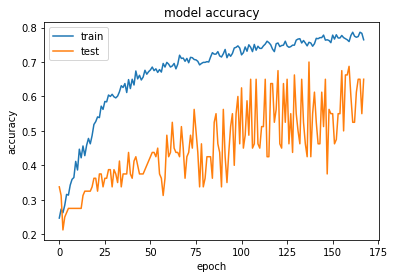

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

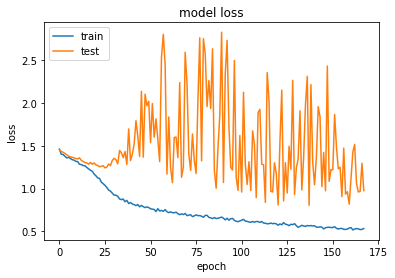

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
model.save('vie-vie-model.h5')